# Predicting movement of the DJIA using general public sentiment as expressed by Twitter
Peter Barty, Sidharth Verma, Aarushi Wadhwa


## Introduction



Using sentiment analysis to predict stock market movements has been a hot topic of late. Numerous studies [1] [2] have been done investigating this trend.

In 2010, Bollen, Mao, and Zeng [1] published their study which established a trend between differing profiles of Twitter mood (both binary classification and categorical classification) and the Dow Jones Industrial Average (DJIA) using a self-organizing fuzzy neural network model (SOFNN). Pagolu, et. al. performed a similar analysis on a restricted set of stocks, and restricted Tweets to be related to those stocks. They then performed sentiment analysis using multiple models, including a support vector machine (SVM) [2]. 

We investigate the relationship of Twitter sentiment and the DJIA on a micro-scale. More specifically, we analyze the relationship between DJIA changes within hours, and Twitter sentiment during that last hour. 

### Collecting DJIA data

Dow Jones data was collected using the AlphaVantage API. This API also requires a key to access, and can be obtained at https://www.alphavantage.co/support/#api-key. 

AlphaVantage offers intraday data, i.e. open/high/low/close quotes for stocks at hourly intervals for free for up to fifteen days. 

Entering the following command in a Unix-like terminal, equipped with cURL will download a CSV file from AlphaVantage with open, high, low, and close values for the DJIA at 60 minute intervals from the last 10-15 days. 

curl -o djia.csv  "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=.DJI&interval=60min&apikey=API_KEY_HERE&datatype=csv"


### Collecting Twitter data

Twitter data was gathered using TweePy, and stock data was gathered using the AlphaVantage REST API. The TweePy API is a front-end to the Twitter REST API for Python. Twitter requires the creation of a API keys, which can be generated at: https://developer.twitter.com/en/docs/basics/getting-started#get-started-app. 

The Twitter data collected spanned seven days during active hours of the stock market. The included analyzed tweets came from a series of search queries deemed to most likely relate to sentiment. These were Tweets that contained the words “i feel","i am feeling","i’m feeling","i dont feel", or "makes me". 

Due to rate limiting, as well as the sheer amount of data, data collection can take hours to complete. To safeguard against interruptions, the code below that queries the TweePy API also implements a logging system that stores the last Tweet ID in a log file, which can be replayed in the event of an interruption to ensure that Tweets are not duplicated, and that queries only return Tweets that have not been seen before. 


In [10]:
### set up API access ###
import json
import jsonpickle
import tweepy
import pandas as pd
# load in keys
consumerKey = "INSERT HERE"
consumerSecret = "INSERT HERE"
accessToken = "INSERT HERE"
accessSecret = "INSERT HERE"

# generate OAuthHandler instance by passing in the consumer key and secret
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessSecret)

# set up API interface
myAPI = tweepy.API(auth, wait_on_rate_limit=True,
                  wait_on_rate_limit_notify=True)

In [ ]:
### collect tweets with REST API ###
searchQueries = ["i feel","i am feeling","i’m feeling","i dont feel", "makes me"]
twtsPerQry = 100 # max per pull request
exportFile = 'individualExport.txt'
logFile = 'logfile.txt'

for query in searchQueries:
    numTwts = 0
    maxTwtID = -1
    q = query + ' -filter:links'
    with open(logFile, 'a') as l:
        with open(exportFile,'a') as f:
            try:
                while True: # collect data as far is the database goes back (7 days)
                    if maxTwtID <0:
                        newTwts = myAPI.search(q=q, count=twtsPerQry)
                    else:
                        newTwts = myAPI.search(q=q, count=twtsPerQry, max_id = str(maxTwtID-1))
                    if not newTwts:
                        print('no more tweets')
                        break
    
                    for tweet in newTwts:
                        # write tweet to file for later processing
                        f.write(jsonpickle.encode(tweet._json, unpicklable=False) + '\n')
                        maxTwtID = newTwts[-1].id
                    
                    numTwts += len(newTwts)
                    # keep track of tweets collected in case of error
                    l.write("%s,%d,%d" %(query, maxTwtID, numTwts) +'\n')
                    print("For %s, downloaded %d" % (query, numTwts))
                    
            except BaseException as e:
                print('Error: '+str(e))



Both Twitter and DJIA index were stored in .txt/.csv files so that they could be easily accessed later and shared between devices. In order to access the data, the following code was run.

In [11]:
### collect TWITTER data ###
import sklearn
import pandas as pd
import json
from textblob import TextBlob
import re
import numpy as np

def collectTweets():
    data = []
    datafiles = ['makesmeidont.txt', 'imfeeling.txt']
    for file in datafiles:
        with open(file, 'r') as f:
            l = 0
            for line in f:
                if l % 8 == 0:
                    data.append(json.loads(line))
                l = l + 1
    print("Done loading to memory")

    df = pd.DataFrame(data)
    return df

df = collectTweets()
df.head()

Done loading to memory


,contributors,coordinates,created_at,entities,favorite_count,favorited,geo,id,id_str,in_reply_to_screen_name,...,lang,metadata,place,retweet_count,retweeted,retweeted_status,source,text,truncated,user
0,None,None,Sun May 06 08:16:22 +0000 2018,"{'hashtags': [], 'symbols': [], 'urls': [], 'u...",0,False,None,993041771226714112,993041771226714112,None,...,en,"{'iso_language_code': 'en', 'result_type': 're...",None,0,False,NaN,"<a href=""http://twitter.com/download/android"" ...",I still dont feel so good,False,"{'contributors_enabled': False, 'created_at': ..."
1,None,None,Sun May 06 08:13:58 +0000 2018,"{'hashtags': [], 'symbols': [], 'urls': [], 'u...",0,False,None,993041165279776769,993041165279776769,None,...,en,"{'iso_language_code': 'en', 'result_type': 're...",None,105,False,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com/download/iphone"" r...",RT @tangerinetearss: i get attached way too ea...,False,"{'contributors_enabled': False, 'created_at': ..."
2,None,None,Sun May 06 08:08:17 +0000 2018,"{'hashtags': [], 'symbols': [], 'urls': [{'dis...",1,False,None,993039735789535237,993039735789535237,None,...,en,"{'iso_language_code': 'en', 'result_type': 're...","{'attributes': {}, 'bounding_box': {'coordinat...",0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",i started out crying over a tv show but now i ...,True,"{'contributors_enabled': False, 'created_at': ..."
3,None,None,Sun May 06 08:05:41 +0000 2018,"{'hashtags': [], 'symbols': [], 'urls': [], 'u...",0,False,None,993039080228179969,993039080228179969,elayynnee,...,en,"{'iso_language_code': 'en', 'result_type': 're...",None,0,False,NaN,"<a href=""http://twitter.com/download/android"" ...",I just dont feel sleepy at all,False,"{'contributors_enabled': False, 'created_at': ..."
4,None,None,Sun May 06 08:01:02 +0000 2018,"{'hashtags': [], 'symbols': [], 'urls': [], 'u...",0,False,None,993037909551996929,993037909551996929,None,...,en,"{'iso_language_code': 'en', 'result_type': 're...",None,2,False,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com/download/iphone"" r...",RT @_ruudix: Ramadan is the only month i dont ...,False,"{'contributors_enabled': False, 'created_at': ..."


## Pre-processing DJIA data

The Twitter data was processed in order to obtain data in an easy to use format that could be merged seamlessly with data from AlphaVantage, by extracting the day and hour in a standard format. This would later also help aggregate the tweet data into useful inputs for our model.

For each hour in the dataset, the change was defined as the difference between the closing and opening DJIA index values. Our classifier attempted to predict whether this change would be positive or negative for each hour, based on Twitter sentiment. While the trend we are attempting to investigate is at a far more granular scale compared to the studies mentioned above, we believe that simply predicting the sign of the change is a simpler task than attempting to predict the actual value of the change. 


In [12]:
### collect DJIA data ###

def read_djia(filename):
    djia = pd.read_csv(filename)

    djia_timestamp_index = pd.DatetimeIndex(djia['timestamp'])
    djia_timestamp_utc = djia_timestamp_index.tz_localize('US/Eastern').tz_convert('UTC')
    djia['timestamp'] = pd.Series(djia_timestamp_utc)

    max_time = djia['timestamp'].max()
    min_time = djia['timestamp'].min()

    def convert_timestamp_to_day(timestamp):
        day = timestamp.day
        day = day - 23
        if day < 0:
            day = day + 30
        return day

    def convert_timestamp_to_hour(timestamp):
        return timestamp.hour

    def convert_row_to_change(row):
        return row['close'] - row['open']

    data = pd.DataFrame()
    data['day'] = djia['timestamp'].apply(convert_timestamp_to_day)
    data['hour'] = djia['timestamp'].apply(convert_timestamp_to_hour)
    data['time'] = data['day'] + ((data['hour']-14)/7)
    data['change'] = djia.apply(convert_row_to_change, axis=1)
    data.set_index(['day', 'hour'], inplace=True)
    return (data, min_time, max_time)

(djia,min_time,max_time) = read_djia('djia.csv')
djia.head()

time  change
day hour                   
11  20    11.857143  -22.59
    19    11.714286   12.91
    18    11.571429   62.19
    17    11.428571   21.36
    16    11.285714   54.80

## Tweet data processing and sentiment analysis

The collected tweets were analysed using TextBlob. TextBlob builds on NLTK and Patterns libraries to create easy to use natural language processing tools. We used TextBlob’s sentiment analyzer, which outputs two values: polarity and subjectivity. Polarity measures how positive or negative the sentiment of a sentence is and ranges from -1 (very negative) to +1 (very positive). The subjectivity is a measure of how confident the sentiment predictor is on its prediction and ranges from 0 (unconfident) to +1 (confident). Our model uses sentiment both on its own and scaled by multiplying with the subjectivity of the prediction.


Tweets were grouped by hour and several features were extracted summarising the tweets in each hour: total number of positive/negative/neutral tweets, average sentiment and average weighted sentiment. 

In [13]:
### pre-processing Twitter data ###
def initialProcess(df):
    #senti = list(map(sentiTweet, df.text))
    sentiL = []
    subjectivityL = []
    for index, value in df['text'].iteritems():
        senti, subjectivity = sentiTweet(value)
        sentiL.append(senti)
        subjectivityL.append(subjectivity)
    df['senti']= pd.Series(sentiL, index=df.index)# calculate general sentiment for each tweet
    df['subjectivity'] = pd.Series(subjectivityL, index=df.index)
    return df

### sentiment analysis ###

def sentiTweet(text):
    tweet = " ".join(re.findall("[a-zA-Z]+", text)) # analyze on only alphabetic characters
    tweetBlob = TextBlob(tweet.strip()) # create TextBlob object based on tweet
    senti = 0
    subjectivity = 0
    sentCount = 0
    for sent in tweetBlob.sentences: # TextBlob calculates sentiment per sentence in a text, so must sum all sentences
        sentCount += 1
        senti += sent.sentiment.polarity
        subjectivity += sent.sentiment.subjectivity
    if sentCount>0:
        senti/=sentCount
        subjectivity/=sentCount
    return senti, subjectivity

def convert_day(day):
    day = day - 23
    if day < 0:
        day = day + 30
    return day


def senti_and_group(df):
    df.created_at = pd.to_datetime(df.created_at)
    df['hour'] = df['created_at'].dt.hour
    df['day'] = df['created_at'].dt.day
    df['day'] = df['day'].apply(convert_day)

    df = initialProcess(df)

    num_pos = sum(df['senti']>0)
    tot_pos =df['senti'][df['senti']>0].sum()
    df['pos'] = (df['senti']>0).apply( lambda x: int(x))
    df['neg'] = (df['senti'] <0).apply( lambda x: int(x))
    df['neu'] = (df['senti'] ==0).apply( lambda x: int(x))
    df['relative_senti'] = df['senti']*df['subjectivity']
    df= df.groupby(['day','hour']).agg({'pos': np.sum, 'neg':np.sum, 'neu':np.sum, 'senti':np.mean, 'relative_senti':np.mean})
    return df

def tweets_plus_djia():
    tweets = collectTweets()
    tweets = senti_and_group(tweets)
    (djia,min_time,max_time) = read_djia('djia.csv')
    df = pd.concat([djia, tweets], join='outer', axis = 1)#, keys=['day', 'hour'])
    df = df.dropna(how='any')
    return df

df = tweets_plus_djia()
df.head()

Done loading to memory


time  change    pos   neg   neu     senti  relative_senti
day hour                                                               
3   14    3.000000   91.27   46.0  14.0  20.0  0.139783        0.081327
    15    3.142857   97.36   61.0  17.0  18.0  0.113831        0.057902
    16    3.285714  -75.59   88.0  20.0  18.0  0.090384        0.045529
    17    3.428571   48.40  101.0  22.0  23.0  0.069080        0.032330
    18    3.571429   64.69   37.0  26.0  28.0  0.012206       -0.007609

## Data visualization

To get a sense of how Twitter sentiment might be linked to the DJIA price, we overlaid plots of both as in the plot above/below. There is no obvious pattern or correlation between the two, which did not bode well for our prediction attempts. Note that days 5/6 were excluded due to this being a weekend, for which no DJIA data is available.

Done loading to memory


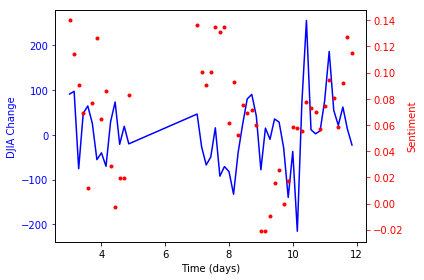

In [15]:
### Visualization ###

df = tweets_plus_djia()

import matplotlib.pylab as plt

def stockVSsenti(df, y1, y2, saved):

    x = df['time']

    fig, djia = plt.subplots()
    djia.plot(x, df[y1], 'b-')
    djia.set_xlabel('Time (days)')
    djia.set_ylabel("DJIA Change", color='b')
    djia.tick_params('y', colors='b')

    sentiment = djia.twinx()
    sentiment.plot(x, df[y2], 'r.')
    sentiment.set_ylabel("Sentiment", color='r')
    sentiment.tick_params('y', colors='r')

    fig.tight_layout()
    fig.savefig(saved, dpi='figure')
    plt.show()

stockVSsenti(df, 'change', 'senti', 'stockvssenti')
plt.show()

## SVM training and cross validation

We trained a support vector machine classifier on our sentiment and stock data using scikit-learn. The regularization parameter was varied and the training and classification accuracy was compared to determine the optimal value for regularization.

In [16]:
### SVM and Cross Validation ###
import sklearn

In [17]:
df = pd.read_csv('processed_tweets.csv')

def obtain_inputs(df):
    # create y results
    y = df['change'].values
    y_bool = y > 0
    y_int = y_bool.astype(int)
    y = y_int
    # create X input
    data_df = pd.DataFrame()
    data_df['pos'] = df['pos']
    data_df['neg'] = df['neg']
    data_df['senti'] = df['senti']
    data_df['neu']=df['neu']
    data_df['relative_senti']=df['relative_senti']
    X = data_df.values
    return X, y

def trainSVM(X_train, y_train, X_cv, y_cv,  reg):
    # train SVM and report training and cross validation accuracies
    svm = sklearn.svm.SVC(kernel='linear', C=reg)
    svm.fit(X_train ,y_train)
    train_acc = svm.score(X, y)
    cv_acc = svm.score(X_cv, y_cv)
    return svm, train_acc, cv_acc


def split_cv_test(X, y):
    # split dataset into train, cross validation and test sets
    test_split, cv_split = 0.6, 0.8
    length = y.shape[0]
    X_train = X[0:int(length*test_split),:]
    X_cv = X[int(length*test_split):int(cv_split*length),:]
    X_test = X[int(cv_split*length):,:]
    y_train = y[0:int(length*test_split),]
    y_cv = y[int(length*test_split):int(cv_split*length),]
    y_test = y[int(cv_split*length):,]
    return X_train, y_train, X_cv, y_cv, X_test, y_test


X,y = obtain_inputs(df)
print('inputs obtained')
regs = list(np.logspace(-6,1,20)) # edit this to make more points on graph
train_accuracies = []
cv_accuracies = []
X_train, y_train, X_cv, y_cv, X_test, y_test = split_cv_test(X,y)
for reg in regs:
    print('training reg:', reg)
    svm, train_acc, cv_acc = trainSVM(X_train,y_train,X_cv,y_cv,reg)
    print(train_acc, cv_acc)
    train_err = 1-train_acc
    cv_error = 1-train_err
    train_accuracies.append(train_acc)
    cv_accuracies.append(cv_acc)



inputs obtained
training reg: 1e-06
0.428571428571 0.5
training reg: 2.33572146909e-06
0.469387755102 0.5
training reg: 5.45559478117e-06
0.469387755102 0.5
training reg: 1.2742749857e-05
0.469387755102 0.5
training reg: 2.97635144163e-05
0.469387755102 0.5
training reg: 6.95192796178e-05
0.469387755102 0.5
training reg: 0.000162377673919
0.469387755102 0.5
training reg: 0.000379269019073
0.571428571429 0.4
training reg: 0.00088586679041
0.571428571429 0.4
training reg: 0.00206913808111
0.571428571429 0.4
training reg: 0.00483293023857
0.571428571429 0.4
training reg: 0.0112883789168
0.571428571429 0.4
training reg: 0.0263665089873
0.591836734694 0.4
training reg: 0.0615848211066
0.632653061224 0.5
training reg: 0.143844988829
0.632653061224 0.5
training reg: 0.335981828628
0.612244897959 0.5
training reg: 0.784759970351
0.612244897959 0.5
training reg: 1.83298071083
0.612244897959 0.5
training reg: 4.28133239872
0.591836734694 0.4
training reg: 10.0
0.591836734694 0.4


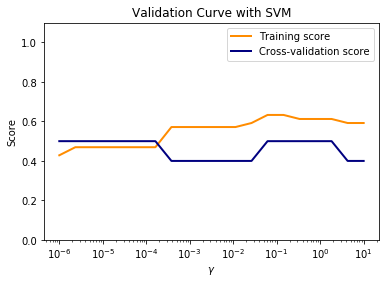

test score: 0.5


In [18]:
### plot validation curve ###
plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(regs, train_accuracies, label="Training score",
             color="darkorange", lw=lw)
plt.semilogx(regs, cv_accuracies, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

# final solution

svm, train_acc, cv_acc = trainSVM(X_train,y_train,X_cv,y_cv,5e-4)
test_score = svm.score(X_test,  y_test)
print('test score:', test_score)



## Results

The above plot shows that our classifier achieved very poor accuracy on both the training and cross-validation datasets, in part due to the limited amount of data. From the plot we determined that the optimal value for the regularization parameter was 5e-4. 

This regularization parameter was used to train our final model, which achieved a prediction accuracy of 50% on our test set.


## Conclusion

Our analysis failed to confirm our hypothesis that general Twitter sentiment can predict the movement of the DJIA. Not only this, but our trained predictor failed to accurately define movement when discretized to the binary increase or decrease in stock price. 

From this, we conclude that, at a micro, intraday scale, there is either no signal in attempting to establish a trend between stock market changes and sentiment, or the signal is not linearly separable. 

## Future work

There were serious limitations in this project caused by difficulty in collecting data over large time periods using the Twitter REST API. This was due to our team only having access to the free-to-use package which limits search data to the last seven days and pull requests to 180 requests every 15 minutes. In order to access larger amounts of data over a long period of time, one can either purchase an expensive package from Twitter or run real-time data collection over a period of months using the Streaming API. An implementation of the latter is detailed below. This implementation would allow us to collect nearly as much data as we would like, as tweets come in. 


In [ ]:
# here's what we would do in the future
# if we wanted to stream the tweets a.k.a. if we had 6 months and a paid server

from tweepy.streaming import StreamListener
import time

#create new class inheriting from the StreamListener Tweepy class
class PDSListener(StreamListener):
    # Listener stops processing after runTime seconds
    def __init__(self, exportFile, runTime=3):
        self.runTime = runTime
        self.startTime = time.time()
        self.currentTime = time.time()
        super().__init__()
        
    #define function to process the tweet as desired:
    def on_data(self, data):
        self.currentTime=time.time()
        # can process as information comes in, in order to reduce the amount
        # of data stored in the json, or can process afterwards
        
        # break processing loop after allocated collection time
        if self.currentTime-self.startTime >= self.runTime:
            print("Collection over.")
            return False
        try:
            with open(exportFile,'a') as f:
                f.write(data)
                return True
        except BaseException as e:
            print('Error: '+str(e))
            return True

exportFile = 'DJIAtweets.json'
tweetListener = PDSListener(exportFile, 3600) # collect tweets for 1 hour --> change this to desired runtime
tweetStream = tweepy.Stream(auth=auth, listener=scandalListener) # open a stream using your defined listener class
tweetKeyWords= ["i feel","i am feeling","i’m feeling","i dont feel", "makes me"]
scandalStream.filter(track=tweetKeyWords, async=True)

In terms of further investigation, there a number of things we would like to do. First, we would like to collect data over a large period of time in order to better fit our models and try to reduce error. An appropriate period of time for this would be at least several months. Secondly, with a much larger dataset available, we would want to train a recurrent neural network using the data as a times series. It is our hypothesis that such a system would be most effective for predicting market movement from tweets. If this yields poor results as our current project has, it would be fair to conclude that the prediction task is infeasible and that there is likely no strong signal for stock market prices in Twitter sentiment.

## Further reading and references

Details on the libraries and tools we used in this project are available to read here:
- Twitter APIs: https://developer.twitter.com/en/docs
- Tweepy: http://docs.tweepy.org/en/v3.5.0/
- TextBlob: http://textblob.readthedocs.io/en/dev/#
- scikit-learn: http://scikit-learn.org/stable/documentation.html
- AlphaVantage: https://www.alphavantage.co

References:

[1]  Johan Bollen, Huina Mao, and Xiao-Jun Zeng. Twitter mood predicts the stock market. CoRR, abs/1010.3003, 2010.

[2]  V. S. Pagolu,  K. N. Reddy,  G. Panda,  and B. Majhi.  Sentiment analysis of twitter data for predicting stock market movements. In 2016 International Conference on Signal Processing, Communication, Power and Embedded System (SCOPES), pages 1345–1350, Oct 2016.
